## Urban Noise Detection:

In this notebook we tackle the urban noise classification problem.

A Dataset of ~8000 labeled .wav files are obtained form (https://urbansounddataset.weebly.com/urbansound.html).

Features are extracted and used to train classification algorithms.

Performance is assessed and discussed.



In [1]:
#import needed libraries

import librosa as lb #used for feature extracion and resampling
import numpy as np 
import matplotlib.pyplot as plt
import librosa.display #builds on matplotlib to draw nice spectrograms.
import IPython.display as ipd #used to play .wav files from notebook
import pandas as pd 
# from scipy.io import wavfile #can be used to import .wav files but does not work on 24 bit depth audio files


import soundfile as sf #soundfile enables loading 24 bit depth audio files.
import time #used to measure code runtime. 
import pickle
import glob
from collections import defaultdict

In [2]:
#functions to be used in this exercise:

#function to read wave file and get numpy file:

def ReadAudio(filename):
    x,sr=sf.read(filename)
    x=x.T #transpose to match format of librosa array representation
    
    #set sample rate at 22050 to reduce memory usage. 
    x=lb.resample(x,sr,22050)
        
    #change any stereo audio to mono.
    if x.shape[0]==2:
        x=lb.to_mono(x)
     
    #change to a list.
    return x,22050





#function to extract Features:
def getFeatures(Sound):
    
    stft=np.abs(lb.stft(Sound))
    mfccs=np.mean(lb.feature.mfcc(y=Sound,sr=22050,n_mfcc=40).T,axis=0)
    chroma=np.mean(lb.feature.chroma_stft(S=stft,sr=22050).T,axis=0)
    mel=np.mean(lb.feature.melspectrogram(Sound,sr=22050).T,axis=0)
    contrast = np.mean(lb.feature.spectral_contrast(S=stft, sr=22050).T,axis=0)
    tonnetz = np.mean(lb.feature.tonnetz(y=librosa.effects.harmonic(Sound),sr=22050).T,axis=0)
    
    
    return mfccs,chroma,mel,contrast,tonnetz



## The first step is visualizing the sounds as numpy arrays. We begin with getting the ID and their corresponding labels.

We also note that the data has been divided into 10 folds. The fold number is shown in the dataframe below.

The folds have been organized by the compilers of the sounds. They have been done in such a way that different folds do not have related sounds.

In [3]:
key=pd.read_csv('AllData/UrbanSound8K/metadata/UrbanSound8K.csv')
key.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
print('The DataFrame has {} entries, {} unique slice_file_names, and {} unique fsIDs'\
      .format(len(key)
        ,len(key.slice_file_name.unique()),
        len(key.fsID.unique())))

The DataFrame has 8732 entries, 8732 unique slice_file_names, and 1297 unique fsIDs


What we can see from above is that some sounds have similar fsIDs. Which means they probably are different slices of the same audio files. Two sounds from the same fsID are probably highly correlated. We check to see if there are fsIDs that repeat in different folds.

In [5]:
A=pd.crosstab(key['fsID'],key['fold'])

A=A!=0 #so we get a 1 is a fold contains the fsid
A=A.astype(int) #change from boolean to integer
#print(A.head())


#we check to see that the sum of each row is just 1 (which means no fsID appears in more than one fold)
Sums=A.sum(axis=1).values

#we also look at how many fsIDs are in more than one fold:
unique,counts=np.unique(Sums,return_counts=True)
print(np.asarray((unique,counts)).T)


[[   1 1292]
 [   2    5]]


We see from above that most fsIDs only appear in one fold (1292), when 5 appear in more 2 folds.
Despite having 5 fsIDS that exist in different folds, the split can be seen as acceptable.


## Feature Visualization

We get 2 sounds from each class.

In [75]:
labels=key['class'].unique()

samples=defaultdict(list)

for label in labels:
    sub=key[key['class']==label]
    samples[label].extend(list(sub.slice_file_name.values[[2,10]]))
    samples[label+'fold'].extend(list(sub.fold.values[[2,10]]))
    print(sub['fsID'].values[[2,10]])

[100652 101281]
[100263 101382]
[100648 118496]
[100852 100852]
[101848 105425]
[110622 135526]
[102853 102871]
[102857 102857]
[103074 103074]
[103199 103199]


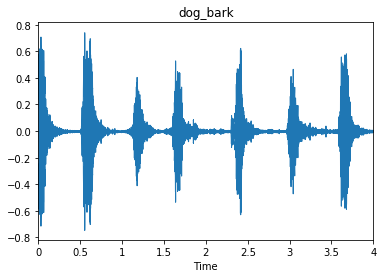

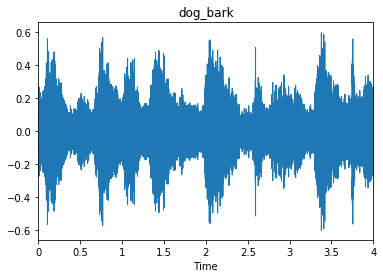

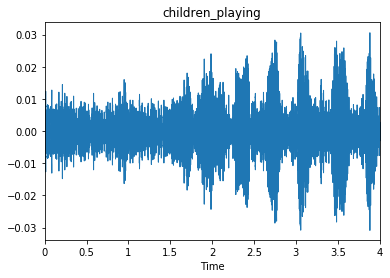

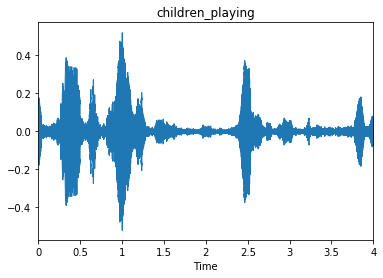

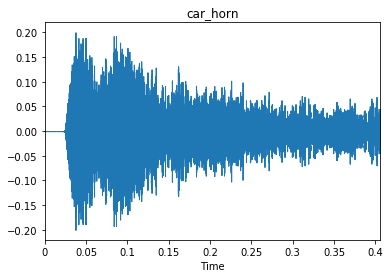

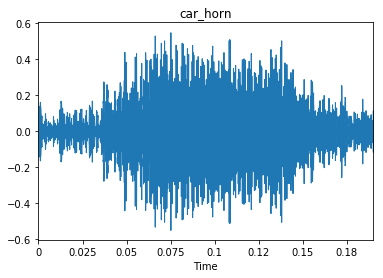

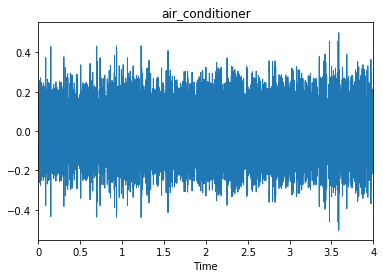

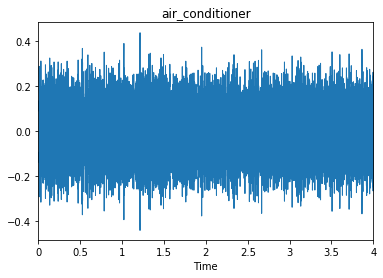

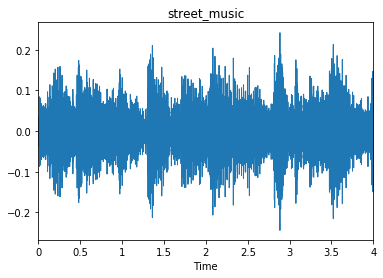

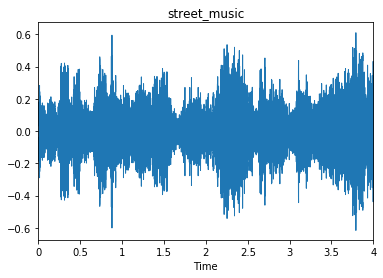

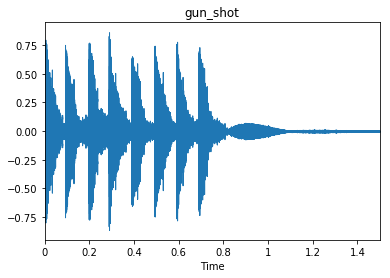

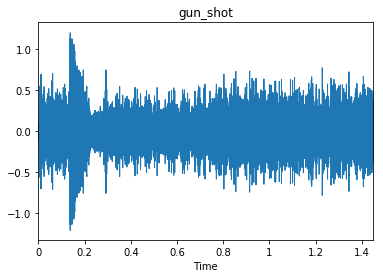

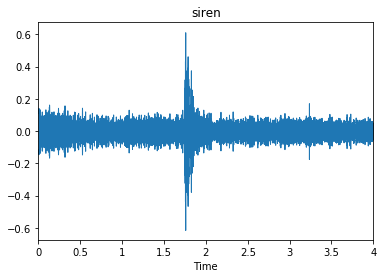

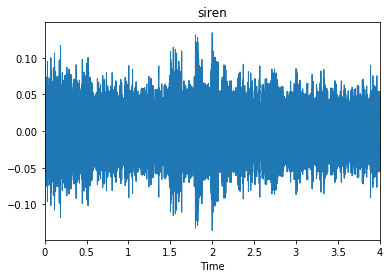

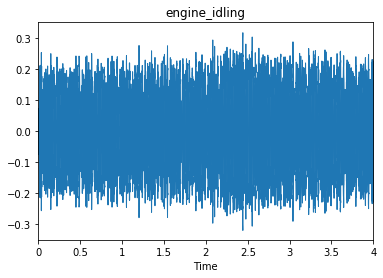

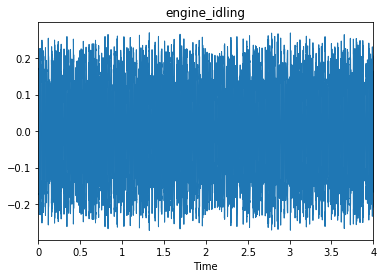

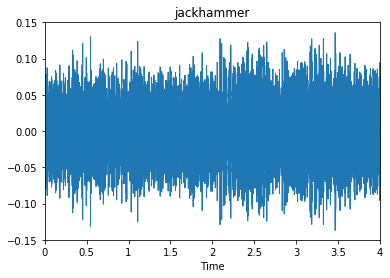

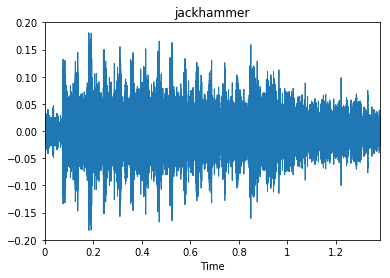

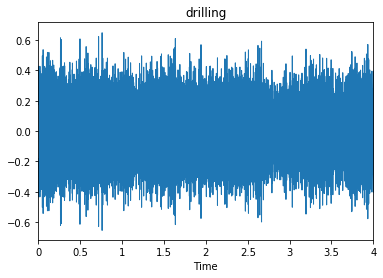

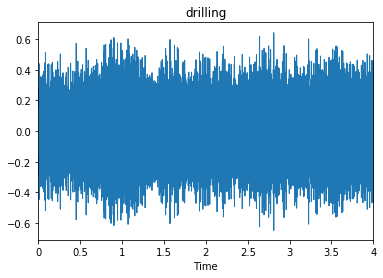

In [76]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        plt.figure()
        lb.display.waveplot(x,sr)
        plt.xlabel('Time')
        plt.title(label)
        plt.show()
        
    

## Discussion:

As can be seen above, the numpy arrays -visually at least- are not the most informative. Moreover, the representation of each sound as a numpy array is memory expensive. 

We investigate looking at mel-scaled spectrogram for the same arrays above.

Mel-scaled spectrograms show the frequency content of a sound with temporal variation. In general a spectrogram shows the frequency content of a wave at different times. That is done by having the x-axis represent time, the y-axis represent different frequency contents. The x-y space is then colored with the corresponding power for a certain frequency at a certain time. 

Studies have shown that human's perception of frequency follows a mel scale (i.e. double the frequency is not perceived as double, but double the mel frequency is). Similarly power is perceived in a logarithmic scale.

Below, we show mel scaled spectrograms (so the y-axis follows a mel scale), and power (i.e the colors in the x-y space) in a logarithmic scale (decibels).

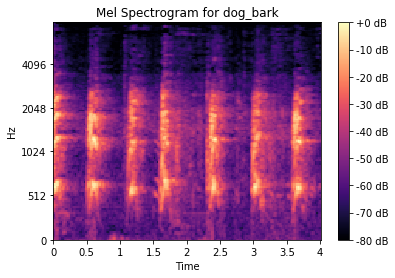

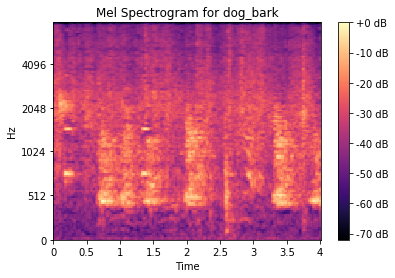

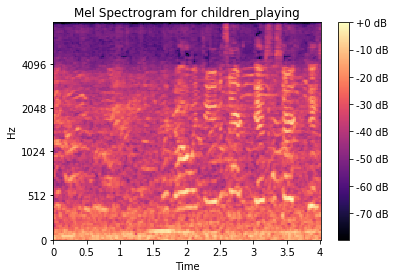

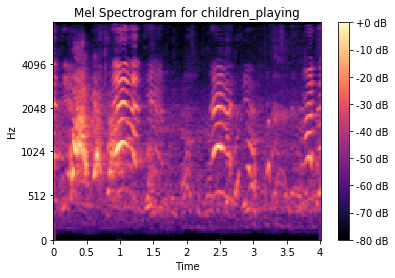

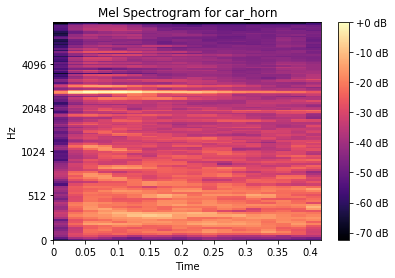

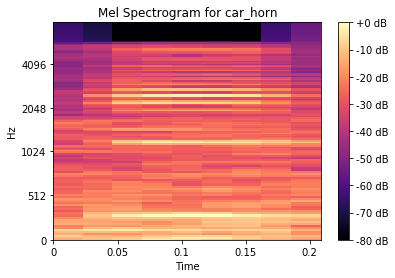

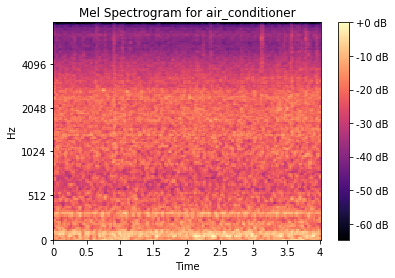

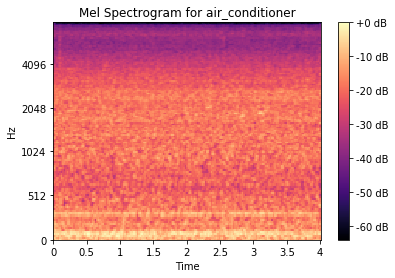

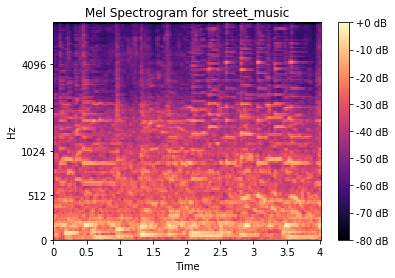

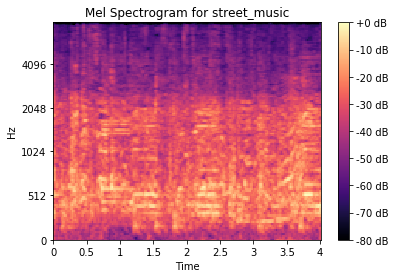

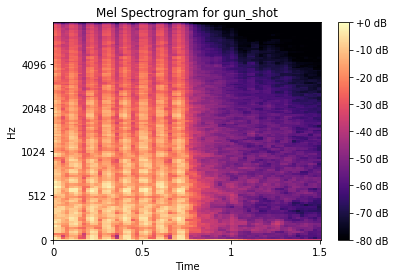

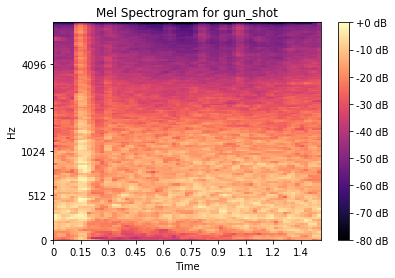

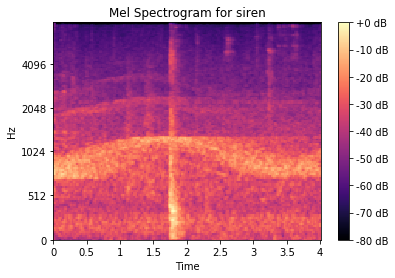

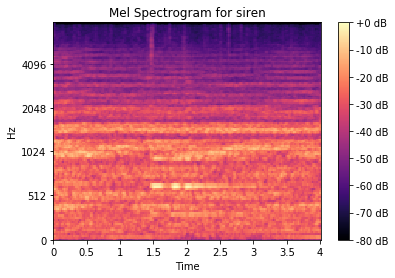

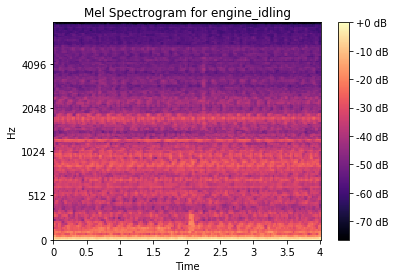

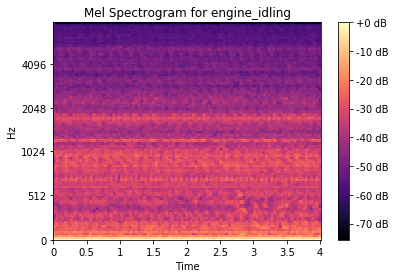

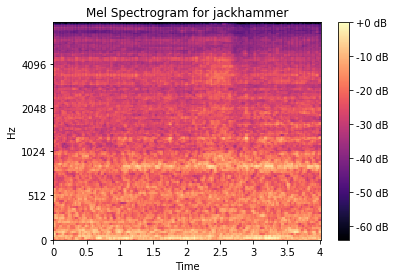

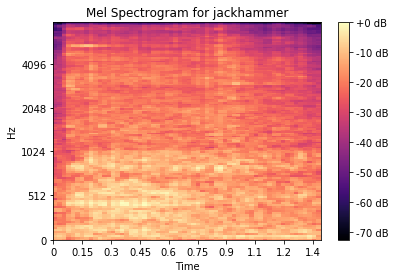

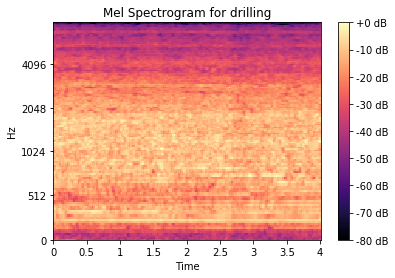

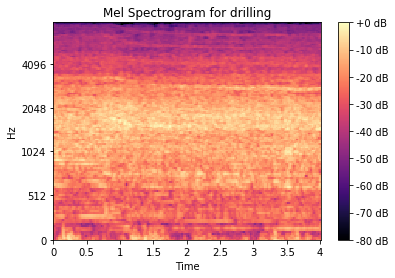

In [77]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        S=lb.feature.melspectrogram(y=x,sr=sr,n_mels=128)
        plt.figure()
        lb.display.specshow(lb.power_to_db(S,ref=np.max),
                           y_axis='mel',
                            fmax=8000,\
                            x_axis='time')

        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram for {}'.format(label))
        plt.show()




    

## Discussion:

We can see that visually, mel-based spectrograms can be useful in differentiating sounds.

A big problem in the above is the lack of homogeneity in duration over the data (see gun shot time axis vs others above). This gives us spectrograms of different shapes. This can cause problems when training classification algorithms.


One way of solving this problem is by averaging the spectrograms temporally. The spectrograms thus go from 128*X matrices, to 128 dimensional vectors (here X is a function of the duration of the sound = duration*samplingrate).


With doing the above, we lose any information that can be obtained from temporal variations. We average the spectrograms shown above temporally and see if the different sounds can still be differentiated.




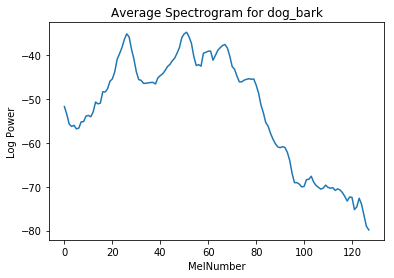

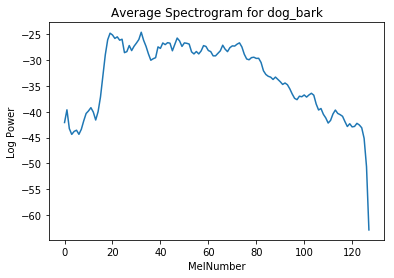

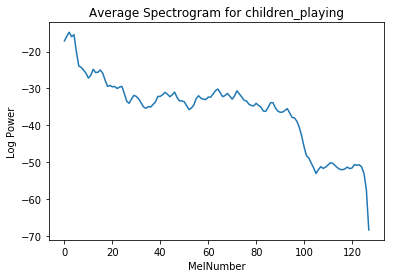

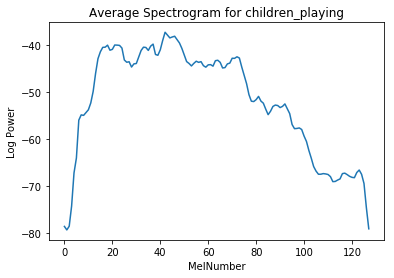

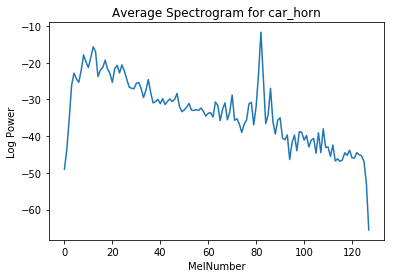

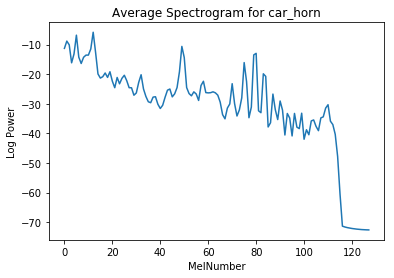

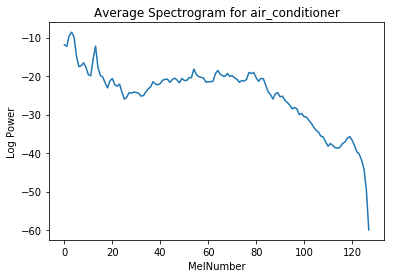

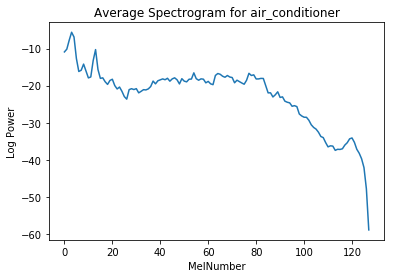

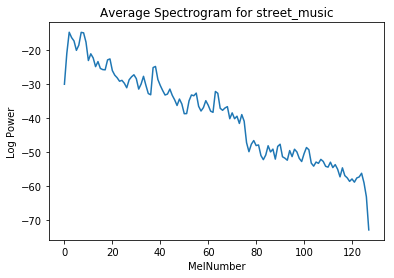

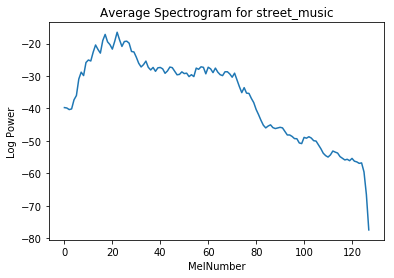

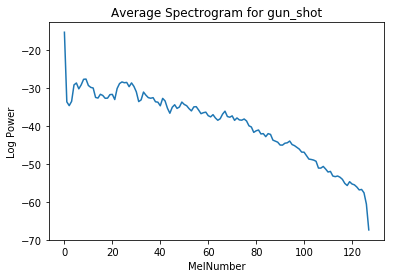

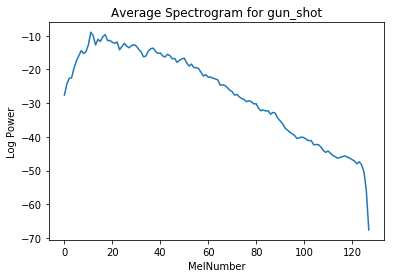

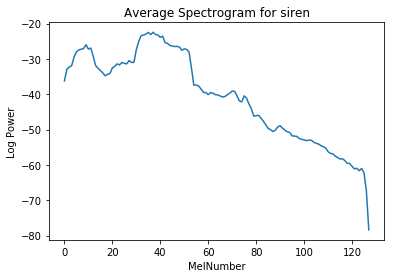

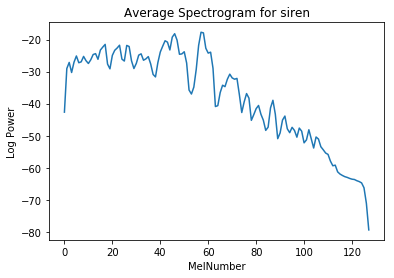

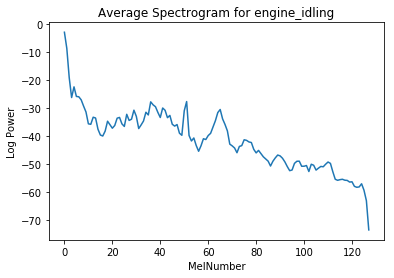

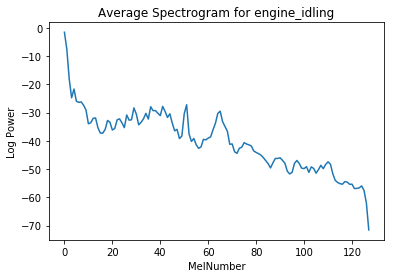

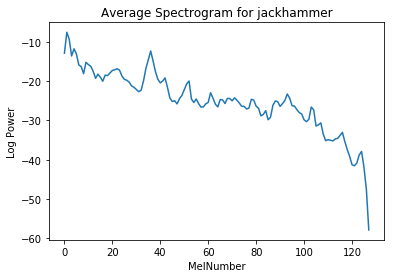

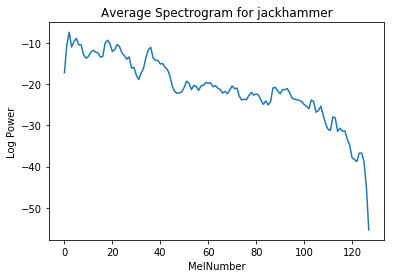

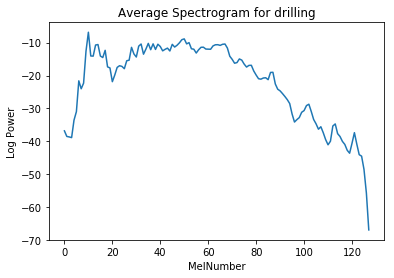

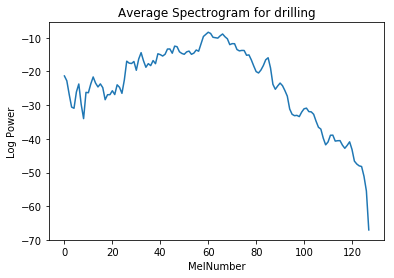

In [78]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        S=lb.feature.melspectrogram(y=x,sr=sr,n_mels=128)
        S=lb.power_to_db(S,ref=np.max)
        S=S.mean(axis=1)
        plt.figure()
        plt.plot(S)
        plt.xlabel('MelNumber')
        plt.ylabel('Log Power')
        plt.title('Average Spectrogram for {}'.format(label))
        plt.show()

## Discussion:

From the above, we actually see that even with temporal averaging, we still see somewhat of a distinction in frequency contents between different sounds.

Of course this study was purely visual, and only with two samples from each class. This should not be conslusive.

## Feature extraction for all sounds:
For every entry in the dataframe key, we extract: MelSpectrogram features.

In [79]:
def getFeatures(Sound):
    
    #stft=np.abs(lb.stft(Sound))
    #mfccs=np.mean(lb.feature.mfcc(y=Sound,sr=22050,n_mfcc=40).T,axis=0)
    #chroma=np.mean(lb.feature.chroma_stft(S=stft,sr=22050).T,axis=0)
    mel=lb.feature.melspectrogram(y=Sound,sr=sr,n_mels=128)
    mel=lb.power_to_db(mel,ref=np.max)
    mel=mel.mean(axis=1)
    mel=mel.T
    #contrast = np.mean(lb.feature.spectral_contrast(S=stft, sr=22050).T,axis=0)
    #tonnetz = np.mean(lb.feature.tonnetz(y=librosa.effects.harmonic(Sound),sr=22050).T,axis=0)
    
    return mel



In [80]:
#we recall what key looks like:
key.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing



MelFeatures=np.zeros((len(key),128))
for i in range(len(key)):
    fold=key.iloc[i,5]
    name=key.iloc[i,0]
    filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +name
    x,sr=ReadAudio(filepath)
    mel=getFeatures(x)
    MelFeatures[i,:]=mel


with open('AllData/Pickles/MelFeatures.pickle','wb') as file:
    pickle.dump(MelFeatures,file)
    
with open('AllData/Pickles/DataInformaion.pickle','wb') as file:   
    pickle.dump(key,file)


In [70]:
#we try a tenfold cross validation scheme with a random forest:
from sklearn.ensemble import RandomForestClassifier

accuracy=[]

for testFold in range(10):
    print(testFold)
    itest=key[key['fold']==testFold+1].index.values
    itrain=key[key['fold']!=testFold+1].index.values
    Xtest=MelFeatures[itest,:]
    Xtrain=MelFeatures[itrain,:]
    ytest=key['class'].values[itest]
    ytrain=key['class'].values[itrain]
    model=RandomForestClassifier(n_estimators=100)
    model.fit(Xtrain,ytrain)
    accuracy.append(model.score(Xtest,ytest))
    
print(accuracy)
    


0
1
2
3
4
5
6
7
8
9
[0.4570446735395189, 0.4358108108108108, 0.4789189189189189, 0.5121212121212121, 0.5502136752136753, 0.47023086269744835, 0.5548926014319809, 0.5781637717121588, 0.6029411764705882, 0.5244922341696535]


In [71]:
np.mean(np.array(accuracy))

0.5164829937085965